# Setup and Additional Functions

In [1]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, csv, math, random as rd
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

Confidence Ellipse code from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html

In [2]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Part 1.1: Single Gaussian

In [3]:
data = pd.read_csv('data.csv', header = None, names = ['X','Y'])
data = data.to_numpy()
data

array([[ 37.39461895,  31.04873877],
       [ -8.16834554, -12.04439852],
       [ 24.30362862,  22.20918302],
       ...,
       [ 28.15031603,  29.59509463],
       [ 35.55857318,  35.29055002],
       [ 23.16939613,  22.22921506]])

To calculate the single Gaussian distribution, we calculate the mean and covariance matrix, and return the probabilities each point is near the center of the cluster.

In [4]:
def single_gauss(data):
    mean = np.mean(data, axis = 0)
    cov = np.cov(np.transpose(data))
    const = 1.0 / math.sqrt(math.pow(2 * math.pi, 3) * np.linalg.det(cov))
    probs = []
    for x in data:
        matrix_bs = math.exp(np.matmul(np.matmul(np.transpose(x-mean), np.linalg.inv(cov)), (x-mean)) / -2)
        probs.append(const * matrix_bs)
    return probs
        
probs = single_gauss(data)
probs

[0.00018251834893927993,
 0.00010161669593134423,
 0.0007971772791362234,
 0.0009425703970715218,
 0.00024189139382982034,
 0.00036580473019651784,
 0.0004653727672698966,
 0.00043507527885342564,
 0.0009216640611172386,
 0.0009162564901588846,
 0.0002757964927156208,
 0.0001273977617134622,
 4.426672488113039e-05,
 0.00016455047479988177,
 0.0004529811172528324,
 0.0005247542636341741,
 0.0005928662971973804,
 0.0009423633714528386,
 0.0004920105127531629,
 0.0009135281100916209,
 3.4041264603518975e-05,
 0.0008620398607635919,
 0.0007265028880183073,
 0.0006730976699111082,
 0.0006389000219228277,
 0.0005952025118237956,
 0.0004918086515521127,
 0.00034948924076746583,
 0.0006047762616430463,
 0.0008966041746224959,
 0.00021723587688538378,
 0.000638928390392821,
 0.0008454293943713594,
 0.00041273803790669526,
 0.000525317829669181,
 8.222116966639847e-05,
 6.829530955620865e-05,
 0.0003444626067186558,
 0.00045365135746459743,
 0.0007851475368917785,
 0.0005003859387192131,
 0.0008

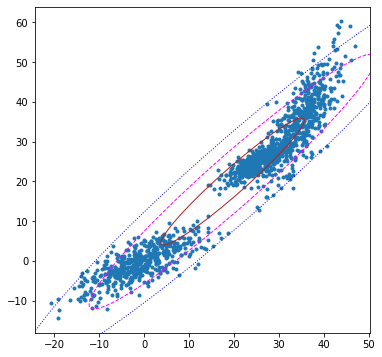

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
x, y = data[:,0], data[:,1]
ax.scatter(x, y, marker = ".")
confidence_ellipse(x, y, ax, n_std=1,
                   label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax, n_std=2,
                   label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax, n_std=3,
                   label=r'$3\sigma$', edgecolor='blue', linestyle=':')
plt.show()

# Part 1.2 Gaussian Mixture Models

We begin by initializing our cluster using the K-means algorithm.

In [6]:
def Kmeans(data, k, show_results):
    #given data and total clusters
    
    #initialize data, iterations, and centroids array (keep track of centroids over iterations)
    m = data.shape[0]
    n = data.shape[1]
    iterations = 100
    centroids = np.array([]).reshape(n,0) #centroids array is n x k, n is total features in data, k is total clusters
    
    #initialize first centroids randomly
    for i in range(k):
        centroids=np.c_[centroids,data[rd.randint(0,m-1)]]
        
    output = []
    #find distance to all points to centroids, and assign initial clusters
    distances = np.array([]).reshape(m,0)
    for i in range(k):
        distances = np.c_[distances,np.sum((data-centroids[:,i])**2,axis=1)] 
        
    mins = np.argmin(distances,axis=1)+1 #mins returns the cluster center it's closest to
    
    #regroup points and assign new clusters
    curr_output = np.empty(k, dtype=object)
    for i in range(k): #initialize arrays
        curr_output[i]=np.array([]).reshape(n,0)
    for i in range(m): #fill arrays with data
        curr_output[mins[i]-1]=np.c_[curr_output[mins[i]-1],data[i]]
    for i in range(k):
        curr_output[i]=curr_output[i].T
    for i in range(k):
        centroids[:,i]=np.mean(curr_output[i],axis=0)
    output = curr_output
    
    #repeat steps for a certain number of iterations (no convergence method used)
    for run in range(iterations):
        #distances and mins
        distances = np.array([]).reshape(m,0)
        for i in range(k):
            distances = np.c_[distances,np.sum((data-centroids[:,i])**2,axis=1)]
        mins = np.argmin(distances,axis=1)+1 #mins returns the cluster center it's closest to
    
        #regrouping and new clusters
        curr_output = np.empty(k, dtype=object)
        for i in range(k): #initialize arrays
            curr_output[i]=np.array([]).reshape(n,0)
        for i in range(m): #fill arrays with data
            curr_output[mins[i]-1]=np.c_[curr_output[mins[i]-1],data[i]]
        for i in range(k):
            curr_output[i]=curr_output[i].T
        for i in range(k):
            centroids[:,i]=np.mean(curr_output[i],axis=0)
        output = curr_output
     
    #show results of k-means clustering
    if(show_results):
        color=['red','blue','green','pink','orange']
        labels=['cluster1','cluster2','cluster3','cluster4','cluster5']
        for i in range(k):
            plt.scatter(output[i][:,0],output[i][:,1],c=color[i],label=labels[i])
        plt.scatter(centroids[0,:],centroids[1,:],s=300,c='yellow',label='Centroids')
        plt.show()
    
    return centroids

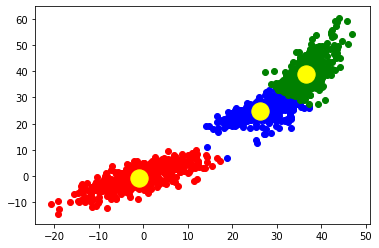

array([[-1.04736119, 26.10187188, 36.61605153],
       [-0.51674251, 24.94237485, 38.78497781]])

In [7]:
Kmeans(data,3,True)

Now that we have the centroids for each cluster located, we can use this in our Gaussian Mixture Model code. This also gives us a stronger starting point for GMM compared to randomly choosing data points and starting from there.

In [8]:
def add_ellipse(x, y, ax, mean, cov, n_std=3.0, facecolor='none', **kwargs):
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [9]:
#rewrite gaussian function from single gaussian to GMM
#we're using our mean and covariance matrix instead of calculating one for a dataset, and generalizing for all dimensions
def gaussian(data, mu, cov):
    n = data.shape[1]
    return np.diagonal(1 / ((2 * np.pi) ** (n / 2) * np.linalg.det(cov) ** 0.5) * np.exp(-0.5 * np.dot(np.dot(data-mu, np.linalg.inv(cov)), (data-mu).T))).reshape(-1, 1)
    
#calculate gamma_nk
def expectation_step(data, clusters):
    m = data.shape[0]
    gamma_nk_sum = np.zeros((m, 1)) #calculate denominator, then calculate individual gamma_nk terms
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = pi_k * gaussian(data, mu_k, cov_k)
        for i in range(m):
            gamma_nk_sum[i] += gamma_nk[i]
            
        cluster['gamma_nk'] = gamma_nk #store numerator here, will eventually update with the final value
        cluster['gamma_nk_sum'] = gamma_nk_sum #pass a reference to the array, this will automatically update
        
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['gamma_nk_sum']
        
    return clusters

In [10]:
def maximization_step(data, clusters):
    N = data.shape[0] #number of data points
    
    for cluster in clusters:
        #initialize values, prepare new covariance matrix
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((data.shape[1], data.shape[1]))
                         
        #define sum of gammas as N_k, useful for later calculations
        N_k = np.sum(gamma_nk, axis=0)
        
        #calculate pi_k, mu_k
        pi_k = N_k / float(N)
        mu_k = np.sum(gamma_nk * data, axis=0) / N_k
             
        #calculate covariance matrix
        for i in range(N):
            diff = (data[i] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[i] * np.dot(diff, diff.T)
                         
        cov_k /= N_k
                         
        #update cluster values
        cluster['pi_k'] = pi_k
        cluster['mu_k+1'] = mu_k
        cluster['cov_k'] = cov_k
                         
    return clusters

In [11]:
def log_likelihood(data, clusters):
    return np.sum(np.log(np.array([cluster['gamma_nk_sum'] for cluster in clusters])))
    
def GMM(data, k, show_results):
    m = data.shape[0]
    n = data.shape[1]
    #Given data and k (number of desired Gaussians)
    #Step 1: Initialization
    clusters = []
    centroids = Kmeans(data, k, False).T
    
    #initialize pi_k, mu_k, and cov_k
    #pi_k scaling factor is 1/# of clusters, assume each cluster is scaled equally
    #mu_k are centroids found from k-means
    #cov_k is identity matrix, assume covariance is not weighted in any direction at the start
    for i in range(k):
        clusters.append({'pi_k': 1.0 / k, 'mu_k': centroids[i], 'cov_k': np.identity(n, dtype=np.float64)})
        
    clusters = expectation_step(data, clusters)
    clusters = maximization_step(data, clusters)
    
    #eventually check is mu_k+1 - mu_k is less than something, that indicates convergence
    tau = np.sum([(np.sum((cluster['mu_k+1'] - cluster['mu_k'])**2)) for cluster in clusters])
    while (tau > .00001):
        #change mu
        for cluster in clusters:
            cluster['mu_k'] = cluster['mu_k+1']
        #run steps again
        clusters = expectation_step(data, clusters)
        clusters = maximization_step(data, clusters)
        #recalculate tau
        tau = np.sum([(np.sum((cluster['mu_k+1'] - cluster['mu_k'])**2)) for cluster in clusters])
    
    #graphical results
    if(show_results):
        fig, ax = plt.subplots(figsize=(6, 6))
        x, y = data[:,0], data[:,1]
        ax.scatter(x, y, marker = ".")
        
        for cluster in clusters:   
            add_ellipse(x, y, ax, cluster['mu_k+1'], cluster['cov_k'], n_std=1, label=r'$1\sigma$', edgecolor='firebrick')
            add_ellipse(x, y, ax, cluster['mu_k+1'], cluster['cov_k'], n_std=2, label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
            add_ellipse(x, y, ax, cluster['mu_k+1'], cluster['cov_k'], n_std=3, label=r'$3\sigma$', edgecolor='blue', linestyle=':')

        plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


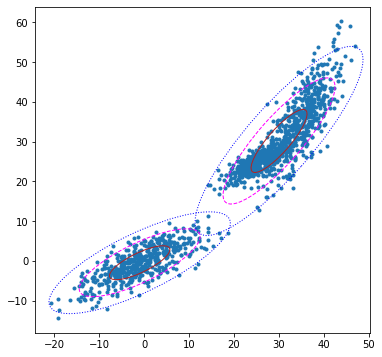

In [13]:
GMM(data, 3, True)